In [1]:
import numpy as np
import tensorflow.keras as k
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

In [2]:
conn = sqlite3.connect('../../data/baza_projekt.db')
counties = pd.read_sql_query('SELECT * FROM unemployment', conn).iloc[:, :3]
counties['FIPS code'] = counties['FIPS code'].astype(str).apply(lambda x: '0'+x if len(x)==4 else x)
conn.close()
counties.head()

,FIPS code,State,Area_name
0,01001,Alabama,Autauga County
1,01003,Alabama,Baldwin County
2,01005,Alabama,Barbour County
3,01007,Alabama,Bibb County
4,01009,Alabama,Blount County


### Trening modeli dla hrabstw

In [3]:
class County:
    def __init__(self, name, fips_code) -> None:
        self.name = name
        self.fips_code = fips_code
        self.feature_vector = np.random.uniform(size=(5,))
        self.f1 = self.feature_vector[0]
        self.f2 = self.feature_vector[1]
        self.f3 = self.feature_vector[2]
        self.f4 = self.feature_vector[3]
        self.f5 = self.feature_vector[4]
        self.virtual_county = self._get_vitrtual_county()
        self.embeding_model = None
    
    def _get_vitrtual_county(self):
        # tutaj będzie ten całwy softmax i tak dalej
        return np.random.uniform(self.feature_vector.shape)
        
    def _set_embeding_model(self, trained_model):
        self.embeding_model = trained_model
    
    def embed(self, array):
        return self.embeding_model.predict(array.reshape(array.shape[0], -1), verbose=0)

    def __str__(self) -> str:
        return f'{self.name}, {self.fips_code}, {self.feature_vector}'


class Person:
    def __init__(self, birthplace: County) -> None:
        self.birthplace: County = birthplace
        self.feature_vector = self.birthplace.feature_vector + np.random.normal(size=self.birthplace.feature_vector.shape) / 4
        self.embeded_vector = None
        self.distance_from_bith = None
        self.migration_history = []

In [4]:
counties_list = []
for idx, row in counties.iterrows():
    counties_list.append(County(row['Area_name'] + ', ' + row['State'], row['FIPS code']))

# Tutaj będziemy zamiast losować w ten sposób, wczytywać dane z pliczy czy widoku SQL, na razie nie ma takiej możliwości (nie chce nam się) 

In [5]:
str(counties_list[0])

'Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472]'

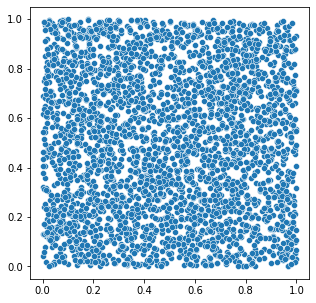

In [6]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=[i.feature_vector[0] for i in counties_list], y=[i.feature_vector[1] for i in counties_list])
plt.show()

In [7]:
N_CLUSTERS = 10
model = KMeans(n_clusters=N_CLUSTERS)
#TODO czy kmeans może samo wybierać liczbę klastrów???
feature_vectors = np.array([c.feature_vector for c in counties_list])

results = model.fit_predict(feature_vectors)

c:\Users\Filif\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


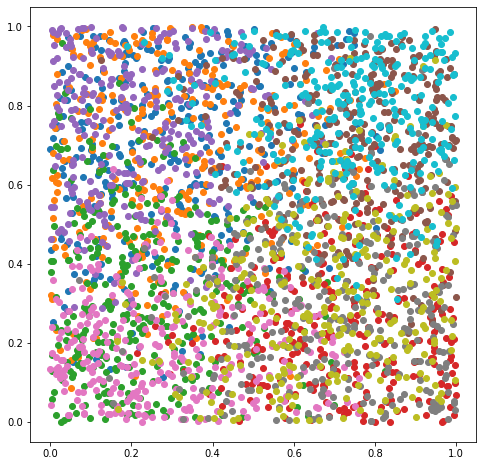

In [8]:
u_labels = np.unique(results)
pca = PCA(2)
df = pca.fit_transform(feature_vectors)
#plotting the results:
plt.figure(figsize=(8,8))
for i in u_labels:
    plt.scatter(feature_vectors[results == i , 0] , feature_vectors[results == i , 1] , label = i)
plt.show()

In [9]:
Y_all = np.array([c.virtual_county for c in counties_list])
for n in range(N_CLUSTERS):
    X = feature_vectors[results == n]
    Y = Y_all[results == n]
    model = k.Sequential([k.layers.Dense(10, activation='relu', input_dim=5),
                          k.layers.Dense(10, activation='relu'),
                          k.layers.Dense(5, activation='relu')])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    print(f'Model for cluster {n+1}')
    model.fit(X, Y, epochs=10, batch_size=10)
    for i, c in enumerate(counties_list):
        if n == results[i]:
            c._set_embeding_model(model)


Model for cluster 1
Epoch 1/10
33/33 [==============================] - 1s 3ms/step - loss: 8.5811 - mse: 8.5811
Epoch 2/10
33/33 [==============================] - 0s 3ms/step - loss: 7.8976 - mse: 7.8976
Epoch 3/10
33/33 [==============================] - 0s 3ms/step - loss: 7.2613 - mse: 7.2613
Epoch 4/10
33/33 [==============================] - 0s 3ms/step - loss: 6.7977 - mse: 6.7977
Epoch 5/10
33/33 [==============================] - 0s 3ms/step - loss: 6.5620 - mse: 6.5620
Epoch 6/10
33/33 [==============================] - 0s 3ms/step - loss: 6.5164 - mse: 6.5164
Epoch 7/10
33/33 [==============================] - 0s 3ms/step - loss: 6.5166 - mse: 6.5166
Epoch 8/10
33/33 [==============================] - 0s 3ms/step - loss: 6.5110 - mse: 6.5110
Epoch 9/10
33/33 [==============================] - 0s 3ms/step - loss: 6.5101 - mse: 6.5101
Epoch 10/10
33/33 [==============================] - 0s 3ms/step - loss: 6.5066 - mse: 6.5066
Model for cluster 2
Epoch 1/10
33/33 [===========

### LOSOWANIE LUDZI

In [10]:
N_LUDZI = 10
people_dict = {}
for county in counties_list:
    people_dict[county] = [Person(county) for _ in range(N_LUDZI)]

### Generowanie nurków

In [11]:
import tqdm 
embeded_pople = []
for ks, v in tqdm.tqdm(people_dict.items()):
    tmp = np.empty((1, 5))
    for prs in v:
        tmp = np.vstack([tmp, prs.feature_vector])    
    predictions = ks.embed(tmp[1:, :])
    for idx, prs in enumerate(v):
        prs.embeded_vector = predictions[idx, :]
    embeded_pople.append(predictions)
embeded_pople = np.array(embeded_pople)
embeded_pople.shape

  0%|          | 4/3145 [00:00<02:59, 17.50it/s]

  0%|          | 7/3145 [00:00<02:43, 19.21it/s]

100%|██████████| 3145/3145 [01:46<00:00, 29.42it/s]


(3145, 10, 5)

In [12]:
embeded_pople = embeded_pople.reshape(-1, 5)

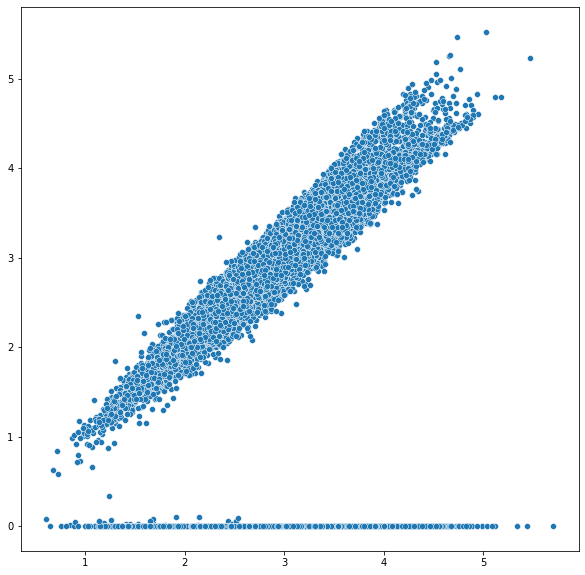

In [13]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embeded_pople[:, 2], y=embeded_pople[:, 0])
plt.show()

In [14]:
embeded_pople /= 5

### Decyzja czy ktoś migruje czy nie

In [15]:
# people_dict[counties_list[0]][0].embeded_vector
for kc, v in people_dict.items():
    for ppl in v:
        ppl.distance_from_bith = np.linalg.norm(ppl.feature_vector - ppl.embeded_vector)

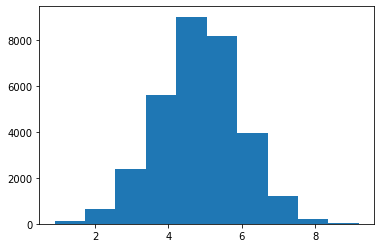

In [16]:
# TODO tutaj trzeba podjebac kod od milcha
krowa = []
for kc, v in people_dict.items():
    for ppl in v:
        krowa.append(ppl.distance_from_bith)
plt.hist(krowa)
plt.show()

In [48]:
from sklearn.neighbors import KDTree
from scipy.special import softmax


tree = KDTree(feature_vectors)

for kc, v in people_dict.items():
    for ppl in v:
        if ppl.distance_from_bith > 6:
            # get closest neighbors
            distances, idxs = tree.query(ppl.embeded_vector.reshape(1, -1), k = 10)
            ppl.migration_history.append(counties_list[np.random.choice(idxs.reshape(-1), p=softmax(distances).reshape(-1))])


In [50]:
for kc, v in people_dict.items():
    for ppl in v:
        print(str(ppl.birthplace),str(ppl.migration_history))

Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Baldwin County, Alabama, 01003, [0.88326366 0.64982672 0.23355929 0.87175146 0.3